# Income Distribution Analysis
Compare income distributions over time

In [125]:
import pandas as pd
import os
import joypy

## Import the data

In [126]:

folder_path = '/Users/Curra/Documents/repos/wage_distribution'

# Initialize an empty list to hold dataframes
dataframes = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and "ACSST1Y" in file_name:  # Check if the file is a CSV and contains "ACSST1Y"
        try:
            # Extract the year from the filename
            year = file_name.split("ACSST1Y")[1][:4]  # Extracts the 4 digits after "ACSST1Y"

            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)  # Read the CSV file

            # Add a 'Year' column to the dataframe
            df['Year'] = year
            
            # Append the dataframe to the list
            dataframes.append(df)
        except (IndexError, ValueError):
            print(f"Skipping file due to unexpected format: {file_name}")

# Combine all dataframes into a single dataframe
combined_data = pd.concat(dataframes, ignore_index=True)


## Clean the Data

In [127]:
# Clean
# Rename the columns
new_column_names = {
    "Label (Grouping)": "label_grouping",
    "United States!!Households!!Estimate": "households_estimate",
    "United States!!Households!!Margin of Error": "households_margin_of_error",
    "United States!!Families!!Estimate": "families_estimate",
    "United States!!Families!!Margin of Error": "families_margin_of_error",
    "United States!!Married-couple families!!Estimate": "married_couple_families_estimate",
    "United States!!Married-couple families!!Margin of Error": "married_couple_families_margin_of_error",
    "United States!!Nonfamily households!!Estimate": "nonfamily_households_estimate",
    "United States!!Nonfamily households!!Margin of Error": "nonfamily_households_margin_of_error"
}

# Apply the renaming
combined_data.rename(columns=new_column_names, inplace=True)


# Replace '%' and '±' symbols in all columns, where applicable
cleaned_data = combined_data.copy()

# Apply the cleaning to all string-type columns
for col in cleaned_data.columns:
    if cleaned_data[col].dtype == 'object':  # Only apply to string columns
        cleaned_data[col] = (
            cleaned_data[col]
            .str.replace('%', '', regex=False)  # Remove percentage symbols
            .str.replace('±', '', regex=False)  # Remove ± symbols
            .str.replace(',', '', regex=False)  # Remove commas
        )

# Display the renamed dataframe
cleaned_data.head()

"""
Cell generated by Data Wrangler.
"""
def clean_data(cleaned_data):
    # Filter rows based on column: 'label_grouping'
    cleaned_data = cleaned_data[(cleaned_data['label_grouping'].str.contains("total", regex=False, na=False)) | (cleaned_data['label_grouping'].str.contains("$", regex=False, na=False))]
    return cleaned_data

cleaned_data = clean_data(cleaned_data.copy())
cleaned_data.head()


,label_grouping,households_estimate,households_margin_of_error,families_estimate,families_margin_of_error,married_couple_families_estimate,married_couple_families_margin_of_error,nonfamily_households_estimate,nonfamily_households_margin_of_error,Year
1,Less than $10000,7.6,0.1,5.0,0.1,1.8,0.1,14.3,0.1,2010
2,$10000 to $14999,5.8,0.1,3.5,0.1,1.8,0.1,10.9,0.1,2010
3,$15000 to $24999,11.5,0.1,8.9,0.1,6.1,0.1,17.4,0.1,2010
4,$25000 to $34999,10.8,0.1,9.6,0.1,7.9,0.1,13.3,0.1,2010
5,$35000 to $49999,14.2,0.1,13.9,0.1,13.1,0.1,14.8,0.1,2010


## Plot the Data

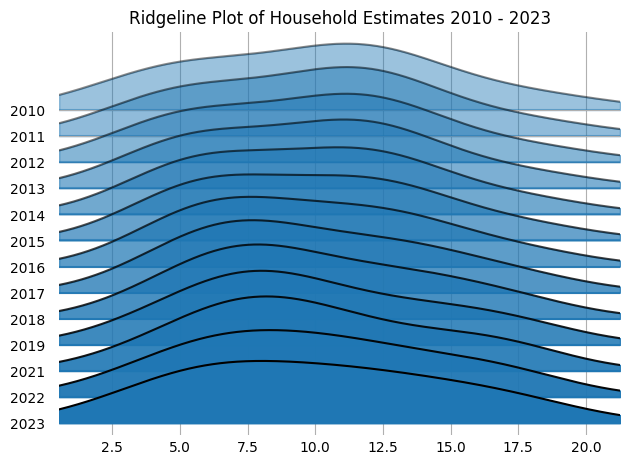

In [128]:
cleaned_data['households_estimate'] = pd.to_numeric(cleaned_data['households_estimate'], errors='coerce')

labels = [
    "Less than $10,000", 
    "$10,000 to $14,999", 
    "$15,000 to $24,999", 
    "$25,000 to $34,999", 
    "$35,000 to $49,999",
    "$50,000 to $74,999",
    "$75,000 to $99,999",
    "$100,000 to $149,999",
    "$150,000 to $199,999",
    "$200,000 or more"
]


fig, ax = joypy.joyplot(
    cleaned_data,
    by = 'Year',
    column = 'households_estimate', 
    title= 'Ridgeline Plot of Household Estimates 2010 - 2023',
    grid = True,
    #hist = True
    #bins = 10,
    #color = colors
    fade = True,
)

plt.show() 

## To Do:
- [ ] Make sure dataset is adjusted for inflation
- [ ] Measure difference between buckets YOY
- [ ] Measure spread in distributions
- [ ] Measure spread YOY
- [ ] Add x label buckets